In [1]:
from matplotlib import pyplot as plt
import numpy as np
from glob import glob
import os
import scipy as sp
from numpy import inf
import pandas as pd

/tmp/ipykernel_79138/476996859.py:7: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
from pytadbit.parsers.hic_bam_parser import get_matrix
from pytadbit.utils.extraviews import plot_HiC_matrix

In [3]:
plt.rcParams["font.family"] = "Arial Narrow"

In [4]:
def plot_trapezoid_genome(m, x=120, y=190, axe=None, title=None, cmap='viridis', bad_color=None,
                         vmin=None, vmax=None, pos=0, npos=1, tads=None):
    if axe is None:
        fig = plt.figure(figsize=(12, 3))
        axe = fig.add_axes((0, 0, 1, 1))
    axe1a, axe1b = plot_HiC_matrix(m, triangular=True, axe=axe, bad_color=bad_color,
                                   vmin=vmin, vmax=vmax, cmap=cmap, transform=lambda x: x)
    
    axe.axison = False
    axe1a.set_ylim(0, (y - x) / 2)

    h = 0.8 / npos
    
    axe1a.set_position((0.01, 0.15 + pos * h, 0.98, h - 0.01))
    axe1b.set_position((0.83, 0.15 + pos * h + 0.85 * h, 0.16, 0.06 * h))
    
    
    axe1b.set_xlabel('')
    axe1b.set_ylabel('')
    axe1a.axison = False

    axe1a.set_xticks([])
    axe1a.set_xticklabels([])
    x0, x1 = axe1a.get_xlim()
    y0, y1 = axe1a.get_ylim()
    axe1b.tick_params(axis='x', labelsize=12)
    axe1a.text(x0 - (x1 - x0) / 30, (y1 + y0) / 2, title, rotation=90, ha='left', size=15)
    return axe1a, axe1b

In [18]:
db_path = 'PATH_TO_FOLDER_WITH_BAM_FILES_MAPPED_WITH_TADBIT'
times = ['0h', '1h', '4h', '7h', '10h', '24h','w24h']#, 'w48h']

# Define region

In [5]:
resolution = 50_000

chrom = "chr1"
start = 15_000_000
end   = 21_000_000

# define tads

In [5]:
tads = pd.read_csv('../../data/ComplementaryData/HiC/aligned_TADbit_TAD-borders.tsv', sep= "\t")

In [6]:
tads = tads.sort_values(['Chromosome', 'position'])
tads

,Chromosome,position,pos_0h,score_0h,density_0h,IS_0h,pos_1h,score_1h,density_1h,IS_1h,...,density_24h,IS_24h,pos_w24h,score_w24h,density_w24h,IS_w24h,pos_w48h,score_w48h,density_w48h,IS_w48h
22,chr1,550000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,11.0,8.0,0.027,0.799884,NaN,NaN,NaN,NaN
39,chr1,887500,NaN,NaN,NaN,NaN,17.0,6.0,0.094,0.828398,...,NaN,NaN,18.0,8.0,2.462,0.198819,NaN,NaN,NaN,NaN
60,chr1,1350000,NaN,NaN,NaN,NaN,27.0,7.0,0.436,0.767976,...,NaN,NaN,27.0,6.0,6.179,0.208175,NaN,NaN,NaN,NaN
69,chr1,1567187,31.0,5.0,0.036,0.796707,NaN,NaN,NaN,NaN,...,NaN,NaN,32.0,8.0,3.678,0.340341,31.0,4.0,0.058,0.715773
81,chr1,1850000,37.0,6.0,1.042,0.644016,37.0,4.0,1.369,0.573500,...,NaN,NaN,37.0,9.0,3.283,0.316758,37.0,4.0,3.910,0.221626
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4415,chrX,153400000,3068.0,8.0,0.585,1.000000,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4417,chrX,153550000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,3071.0,6.0,2.724,0.317383,NaN,NaN,NaN,NaN
4420,chrX,153750000,NaN,NaN,NaN,NaN,3074.0,8.0,0.575,0.889570,...,NaN,NaN,3076.0,10.0,6.134,0.479904,NaN,NaN,NaN,NaN
4425,chrX,154100000,3082.0,10.0,0.315,0.779226,3082.0,10.0,1.097,0.654872,...,0.01,0.722939,3082.0,10.0,2.339,0.575713,3082.0,10.0,0.402,0.800912


# load matrices

In [9]:
matrices = {}

for time in times:
    print(time)
    bam_path = glob(os.path.join(db_path, f'Cabrera_2022_HCT116_WT_*_{time}', 
                                 '03_filtered_reads', 'intersection_*.bam'))[0]
    bias_path = glob(os.path.join(db_path, f'Cabrera_2022_HCT116_WT_*_{time}', 
                                  '04_normalization', 'biases_100kb*'))[0]
    print(" -", chrom)
    matrices[time] = get_matrix(bam_path, resolution=resolution, normalization="norm", 
                                region1=chrom, start1=start, end1=end, 
                                biases=bias_path)

0h
 - chr1
1h
 - chr1
4h
 - chr1
7h
 - chr1
10h
 - chr1
24h
 - chr1
w24h
 - chr1
w48h
 - chr1


In [10]:
size = max(k for t in matrices for kk in matrices[t] for k in kk)

In [11]:
size

119

## transform loaded matrices

In [12]:
for t in matrices:
    tmp = np.zeros((size, size))
    for i in range(size):
        for j in range(size):
            tmp[i, j] = matrices[t].get((i, j), 0)
    tmp /= tmp.sum()
    tmp = np.log2(tmp * 1_000_000)
    tmp[tmp == -inf] = -10
    matrices[t] = tmp

/tmp/ipykernel_17877/2156678902.py:7: RuntimeWarning: divide by zero encountered in log2
  tmp = np.log2(tmp * 1_000_000)


In [79]:
colors = {
    '0h'  : "#fde72580", 
    '1h'  : "#37b57880",
    '4h'  : "#21908d80",
    '7h'  : "#31668d80",
    '10h' : "#43377f80",
    '24h' : "#44015480",
    'w24h': '#fb852480',
#     'w48h': '#00000080',
}

KeyError: 'w48h'

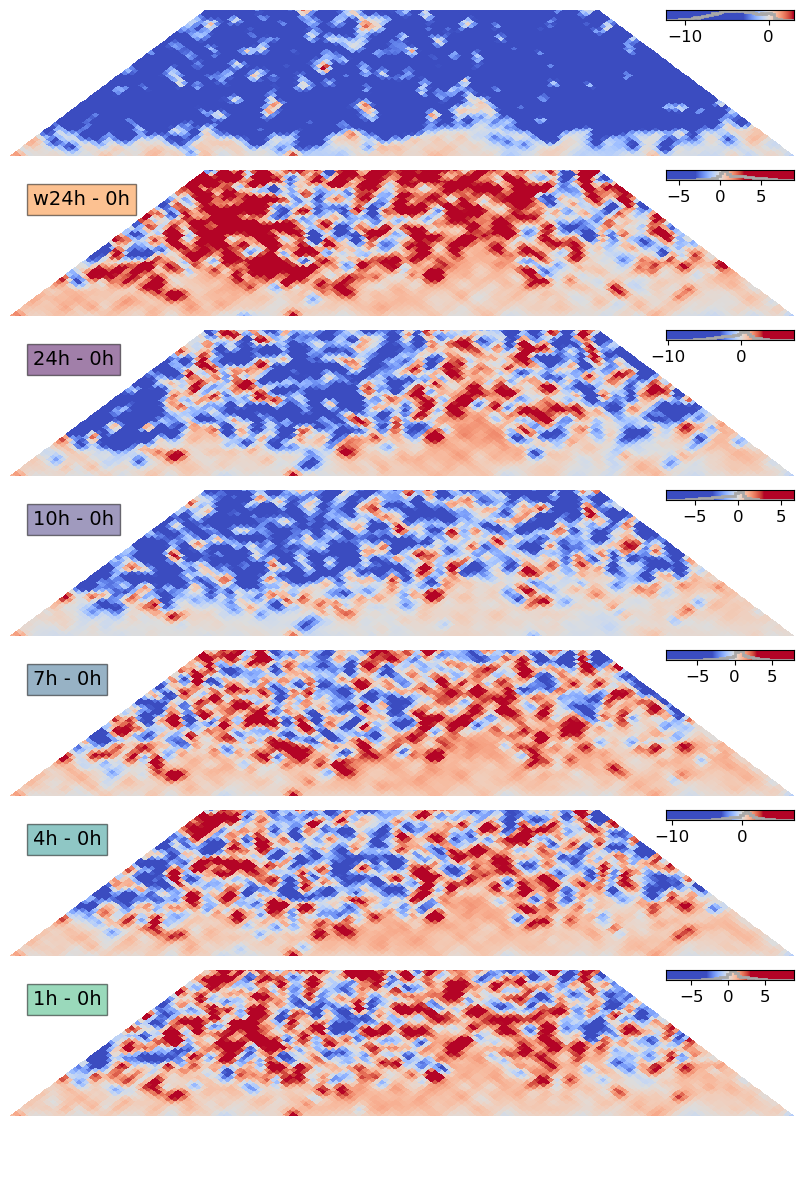

In [14]:
fig = plt.figure(figsize=(8, 14))
t1 = "0h"
t2 = "24h"

sigma = 1  # gaussian smoothing, the lower the more normal (0 is doing nothing)

m1 = matrices[t1]
m1 = sp.ndimage.filters.gaussian_filter(m1, sigma)
axe = plt.subplot(111)
sub_axes = []
for nt, t2 in enumerate(times[1:], 1):
    m2 = matrices[t2]
    m2 = sp.ndimage.filters.gaussian_filter(m2, sigma)
    sub_axe = plot_trapezoid_genome(m2 - m1, x=0, y=size, pos=nt - 1, npos=len(times) - 1,
                                    cmap="coolwarm", vmin=-3, vmax=3, axe=axe)
    sub_axes.append(sub_axe)
    sub_axe.text(size / 40, size / 2.5, f"{t2} - {t1}", va="center", ha="left", size=14, 
                 bbox={"boxstyle": "square", "facecolor": colors[t2], "alpha": 0.5})
plt.subplots_adjust(wspace=0, hspace=0)

sub_axe = sub_axes[0]
sub_axe.plot([0, size], [0, 0], color="k", clip_on=False)
for i in list(range(start, end, (end - start) // 5)) + [end]:
    x = (i - start) / resolution
    sub_axe.plot([x, x], [0, -size / 50], color="k", clip_on=False)
    sub_axe.text(x, -size / 30, f"{i // 1_000_000:,}Mb", clip_on=False, size=13, va="top", ha="center")
sub_axe.text(size / 2, -size / 10, chrom, size=15, va="top", ha="center")

# plt.savefig(f"/home/mcabrera/Desktop/MN/HiC/_{chrom}:{start}-{end}.png",
#             dpi=300)
# plt.savefig(f"//home/mcabrera/Desktop/MN/HiC/_{chrom}:{start}-{end}.pdf", 
#             format="pdf", dpi=300)

In [15]:
for nt, t in enumerate(times[1:], 1):
    print(times)
    m = matrices[t]

['0h', '1h', '4h', '7h', '10h', '24h', 'w24h', 'w48h']
['0h', '1h', '4h', '7h', '10h', '24h', 'w24h', 'w48h']
['0h', '1h', '4h', '7h', '10h', '24h', 'w24h', 'w48h']
['0h', '1h', '4h', '7h', '10h', '24h', 'w24h', 'w48h']
['0h', '1h', '4h', '7h', '10h', '24h', 'w24h', 'w48h']
['0h', '1h', '4h', '7h', '10h', '24h', 'w24h', 'w48h']
['0h', '1h', '4h', '7h', '10h', '24h', 'w24h', 'w48h']


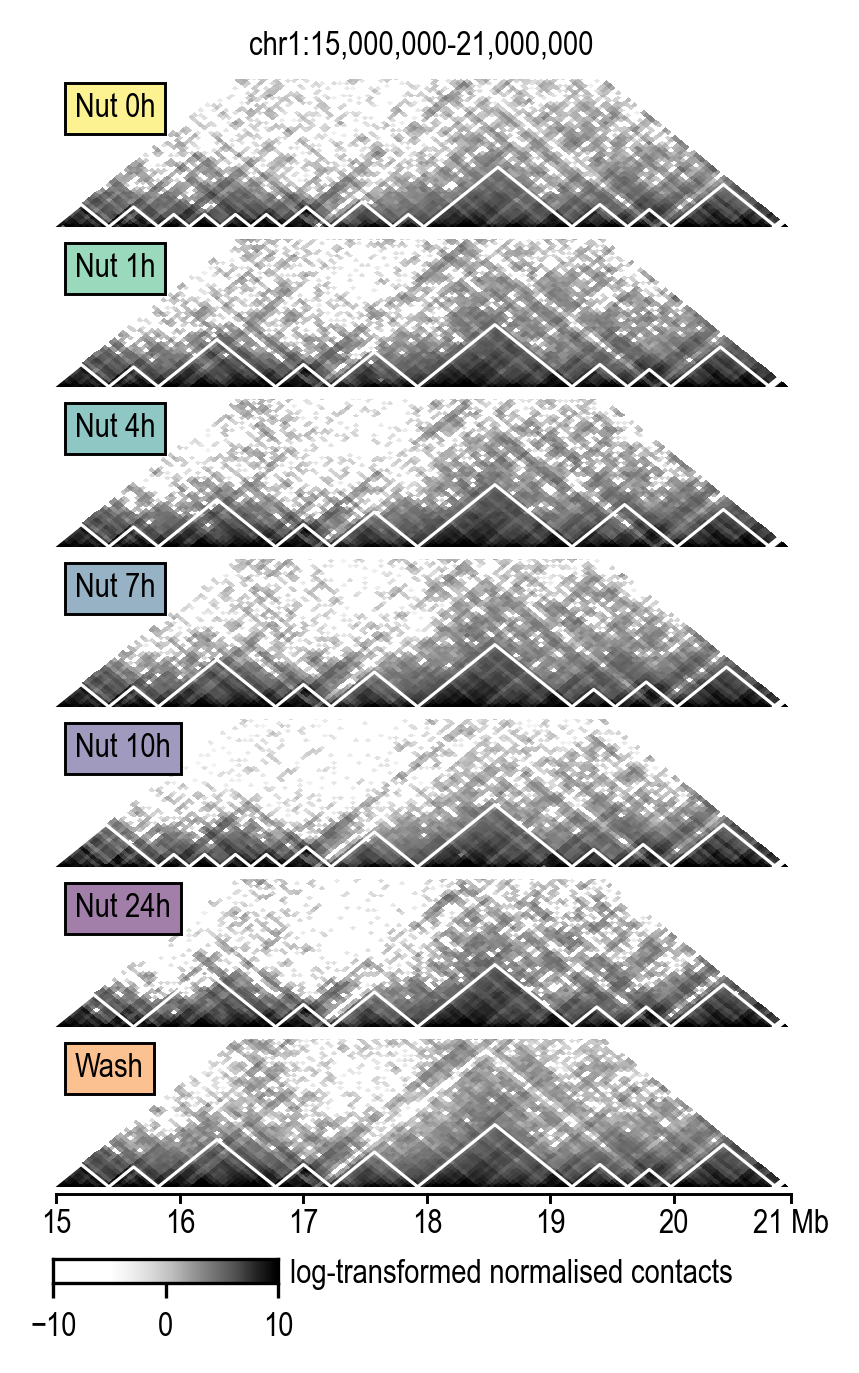

In [81]:
fig = plt.figure(figsize=(2.5, 4), dpi=300)
# fig = plt.figure(figsize=(32, 40))
# colors = ["#F7D03C","#58C765","#21A685","#2E6D8E","#463480","#6A166E"]

sigma = 0.5  # gaussian smoothing, the lower the more normal (0 is doing nothing)
axe = plt.subplot(111)
sub_axes = []

for nt, t in enumerate(times, 0):
    m = matrices[t]
    #m[m==-10] = float('nan')
    m = sp.ndimage.filters.gaussian_filter(m, sigma)
    sub_axe, sub_cax = plot_trapezoid_genome(m, x=0, y=size, pos=len(times) - nt - 1, npos=len(times) - 1,
                                             cmap="Greys", vmin=-5, vmax=10, axe=axe)
    if nt ==0:
        sub_axe.set_title(f"{chrom}:{start:,}-{end:,}", size=8)
    if nt < len(times) - 1:
        sub_cax.clear()
        sub_cax.axison = False
    else:
        sub_cax.set_position((0.01, 0.07, 0.3, 0.02))
        sub_cax.tick_params(labelsize=8)
        sub_cax.set_xlim(-10, 10)
        sub_cax.patches[0].remove()
    #### Pintar tads en las matrices
    beg = start
    for _, line in tads.iterrows():
        if line[0] != chrom:
            continue
        if not (line[1] > start and line[1] < end):
            continue
        if not line[3 + nt * 4] > 4:
            continue
        final = line[2 + nt * 4] * resolution #line[1]
        x1  = (beg - start) / resolution
        x2  = (final - start) / resolution
        off = 0.5
        sub_axe.plot([x1 - off, (x1 + x2) / 2 - off, x2 - off],
                     [0,(x2 - x1),0],color="w", lw=0.75)
        beg=final
    x1 = x2
    x2 = (end - start) / resolution
    sub_axe.plot([x1 - off, (x1 + x2) / 2 - off, x2 - off],
                 [0,(x2 - x1),0],color="w")    
    ############# fin pintar tads
    
    sub_axes.append(sub_axe)
    sub_axe.text(size / 40, size / 2.5, "Wash" if t.startswith("w") else f"Nut {t}", 
                 va="center", ha="left", size=8, 
                 bbox={"boxstyle": "square", "facecolor": colors[t], "lw": 0.7})
plt.subplots_adjust(wspace=0, hspace=0)

sub_axe = sub_axes[-1]
h = size / 40
sub_axe.plot([0, size], [-h, -h], color="k", clip_on=False, lw=0.7)
for i in range(start, end, (end - start) // 6):
    x = (i - start) / resolution
    sub_axe.plot([x, x], [-h, -h * 2], color="k", clip_on=False, lw=0.7)
    sub_axe.text(x, -h * 3, f"{i // 1_000_000:,}" + ("Mb" if i == end else ""), 
                 clip_on=False, size=8, va="top", ha="center")

sub_axe.plot([size, size], [-h, -h * 2], color="k", clip_on=False, lw=0.7)
sub_axe.text(size, -h * 3, f"{end // 1_000_000:,} Mb", clip_on=False, size=8, va="top", ha="center")

sub_cax.text(11, 0, "log-transformed normalised contacts", size=8)

# plt.savefig(f"stacked_HiC-matrices_TADs_{chrom}:{start}-{end}.pdf", format="pdf", dpi=500,bbox_inches = 'tight')